In [1]:
#PLOTTING SPECTRA AND EXTRACTING DIPS DATA

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d



data_path = '/mnt/AR-Drive-2/OpenLab/Spectroscope Data Observations/spectoscope/Vega/20_08_43'
stellar_source = 'Vega'


calibration_coefficients = [-7.87006027e-05, -3.80749635e-02,  7.11501856e+02]

def calibrate_spectrum(pixel_positions):
	return np.polyval(calibration_coefficients, pixel_positions)

min_distance = 10  # Adjust as needed
prominence = 70000  # Adjust as needed

file_array = []

# Create and open a CSV file for saving the peaks
output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df = pd.read_csv(output_file_name_cropped_data)

#print(df)

output_file_name_cropped_data = stellar_source + '-Data-Cropped.csv'
df_spectra = pd.read_csv(output_file_name_cropped_data)

output_file_name_dips_data = stellar_source + '-Data-Dips.csv'
df_dips = pd.read_csv(output_file_name_dips_data)

weight_file = 'sensor-weight-data.csv'
df_weights = pd.read_csv(weight_file)


optimal_shifts = df_dips['Optimal Shift'].values

# Create bins
bin_width = 1
bins = np.arange(3000, 7500+bin_width, bin_width)  # Adjust bin width as needed5
#print(bins)
global_bins = np.zeros(len(bins) - 1)
global_intensity_sum = np.zeros(len(bins) - 1)
bin_intensity_values = [[] for _ in range(len(bins) - 1)]

def resample_weights(wavelength_range_vega, weight_vega, bins):
	interp_func = interp1d(wavelength_range_vega, weight_vega, kind='linear', fill_value='extrapolate')

	weights_resampled = interp_func(bins)
	
	return weights_resampled


for index, row in df_spectra.iterrows():
	new_intensity_values_along_y = row.iloc[1:].values
	new_intensity_values_along_y = new_intensity_values_along_y * 3 * 1e6 / np.max(new_intensity_values_along_y)
	
	calibrated_wavelengths = 10 * calibrate_spectrum(range(len(new_intensity_values_along_y)))
	spec_shift = optimal_shifts[index]
	calibrated_wavelengths = calibrated_wavelengths + spec_shift
	
	weights_source = resample_weights(df_weights['Wavelength(A)'], df_weights['Weight'], calibrated_wavelengths)

	bin_indices = np.digitize(calibrated_wavelengths, bins, right=True)

	for i, bin_index in enumerate(bin_indices):
		if bin_index > 0 and bin_index < len(bins):
			global_bins[bin_index - 1] += 1
			global_intensity_sum[bin_index - 1] += new_intensity_values_along_y[i]*weights_source[i]
			bin_intensity_values[bin_index - 1].append(new_intensity_values_along_y[i]*weights_source[i])

	#print(global_bins)
	# if index == 0:
	# 	plt.figure(figsize=(10, 6))
	# 	plt.plot(calibrated_wavelengths, new_intensity_values_along_y, color='blue', label='Calibrated Spectrum')
	# 	plt.plot([calibrated_wavelengths[pixel_position] for pixel_position in dips], [new_intensity_values_along_y[pixel_position] for pixel_position in dips], 'ro', markersize=5, label='Detected Dips')
	# 	plt.xlabel('Wavelength (nm)')
	# 	plt.ylabel('Intensity')
	# 	plt.title('Star Spectrum with Detected Dips (Absorption Features)')
	# 	plt.legend()
	# 	plt.grid(True)
	# 	plt.show()
	# 	plt.close()

	# 	print(index)
	# 	print('Detected Dips (Absorption Features):')
	# 	for pixel_position, wavelength in dips_wavelengths.items():
	# 		print(f'Pixel Position: {pixel_position}, Wavelength: {wavelength} nm')
	# 	print()

# Print counts for each bin
# print("Global Bin Counts:")
# print(global_bins)
# print(global_intensity_sum/global_bins)

bin_std_dev = [np.std(values) for values in bin_intensity_values]
bin_std_dev = np.array(bin_std_dev)

bins = bins[:-1] + bin_width
global_mean_intensity = global_intensity_sum / global_bins
global_mean_intensity = np.nan_to_num(global_mean_intensity, nan=0, posinf=0, neginf=0)
non_zero_mask = global_mean_intensity != 0
global_mean_intensity = global_mean_intensity[non_zero_mask]
bins = bins[non_zero_mask]

bin_std_dev = bin_std_dev[non_zero_mask]

smooth = savgol_filter(global_mean_intensity, window_length=30, polyorder=5)
dips, _ = find_peaks(-smooth, distance=min_distance, prominence=prominence)
dips_wavelengths = {pixel_position: bins[pixel_position] for pixel_position in dips}

C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\USER\AppData\Local\Temp\ipykernel_4064\2933066644.py:106: RuntimeWarning: invalid value encountered in divide
  global_mean_intensity = global_intensity_sum / global_bins


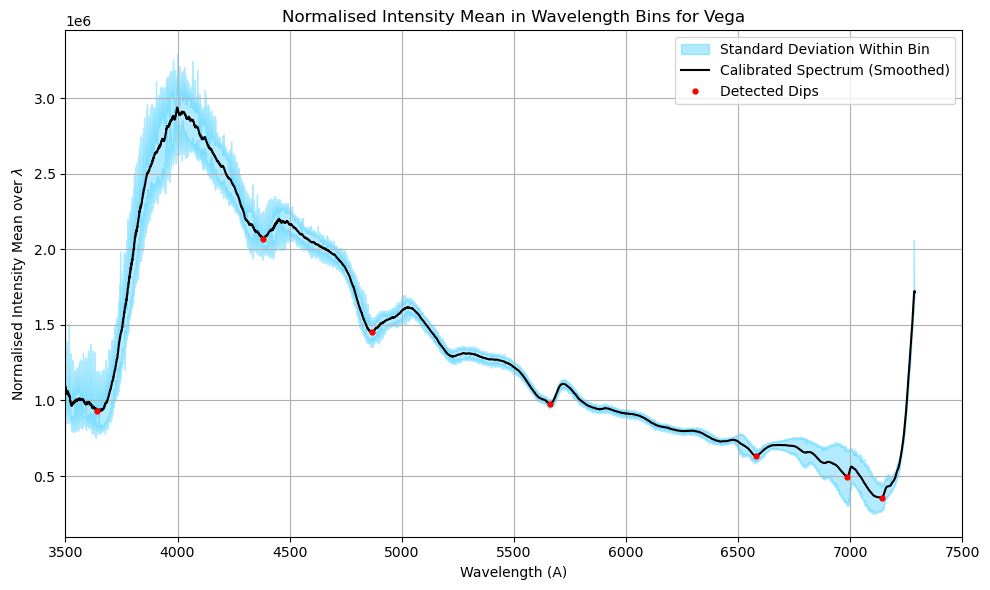

In [2]:
#STUPIDER
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum (Smoothed)')
plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=3.5, label='Detected Dips')
plt.xlabel('Wavelength (A)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title('Normalised Intensity Mean in Wavelength Bins for Vega')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

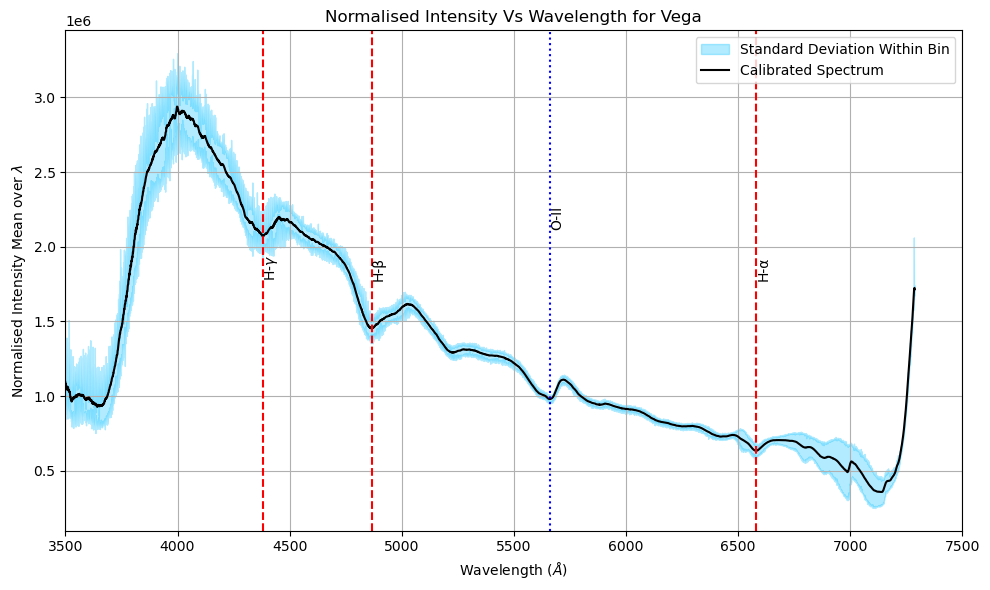

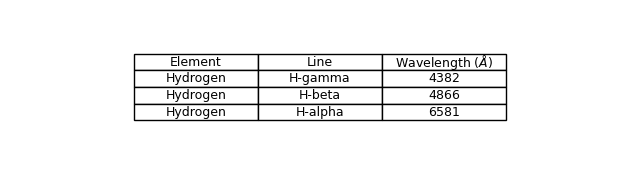

In [40]:
#STUPIDER
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.3, label='Standard Deviation Within Bin')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='black', label='Calibrated Spectrum')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title(f'Normalised Intensity Vs Wavelength for {stellar_source}')
plt.xlim(3500, 7500)
plt.legend()
plt.grid(True)

# Add labels for the lines
h_alpha_wavelength = 6581  
plt.axvline(x=h_alpha_wavelength, color='r', linestyle='--', label='H-α')
plt.text(h_alpha_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-α', rotation=90, verticalalignment='bottom')

h_beta_wavelength = 4866  
plt.axvline(x=h_beta_wavelength, color='r', linestyle='--', label='H-β')
plt.text(h_beta_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-β', rotation=90, verticalalignment='bottom')

h_gamma_wavelength = 4382  
plt.axvline(x=h_gamma_wavelength, color='r', linestyle='--', label='H-$\gamma$')
plt.text(h_gamma_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-$\gamma$', rotation=90, verticalalignment='bottom')

o2_wavelength = 5661  
plt.axvline(x=o2_wavelength, color='b', linestyle=':', label='O-II')
plt.text(o2_wavelength, plt.ylim()[1] - 0.4 * (plt.ylim()[1] - plt.ylim()[0]), 'O-II', rotation=90, verticalalignment='bottom')


plt.tight_layout()
plt.savefig('Vega Spectrum.png')
plt.show()


table_data = [['Element', 'Line', 'Wavelength ($\AA$)'],
              ['Hydrogen', 'H-gamma', h_gamma_wavelength],
              ['Hydrogen', 'H-beta', h_beta_wavelength],
              ['Hydrogen', 'H-alpha', h_alpha_wavelength]
             ]

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')  # Hide the axes
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2])


plt.savefig('Vega_table.png')
plt.show()

In [4]:
# Define a function to identify and analyze absorption lines
def identify_absorption_lines(wavelengths, intensities, dips):
    absorption_lines = {}

    for dip_position in dips:
        # Extract a small window around the dip for analysis
        window_size = 20
        start_index = max(0, dip_position - window_size // 2)
        end_index = min(len(wavelengths), dip_position + window_size // 2)

        # Extract data within the window
        window_wavelengths = wavelengths[start_index:end_index]
        window_intensities = intensities[start_index:end_index]

        # Identify the minimum point within the window as the dip
        min_intensity_index = np.argmin(window_intensities)
        dip_wavelength = window_wavelengths[min_intensity_index]
        dip_intensity = window_intensities[min_intensity_index]

        # Store the identified absorption line
        absorption_lines[dip_wavelength] = dip_intensity

    return absorption_lines

# Identify absorption lines in the global spectrum
global_absorption_lines = identify_absorption_lines(bins, smooth, dips)

# Print identified absorption lines (wavelength and intensity)
print("Identified Absorption Lines:")
for wavelength, intensity in global_absorption_lines.items():
    print(f"Wavelength: {wavelength:.2f} A, Intensity: {intensity:.2f}")


# Read element mapping from the text file
element_mapping_file = 'C:/Users/USER/desktop/Spectroscope/Vega/element_wavelengths.txt'  # Replace with your file path
with open(element_mapping_file, 'r') as file:
    element_mapping_lines = file.readlines()

# Parse element mapping lines
element_mapping = {}
for line in element_mapping_lines:
    parts = line.split()
    element_name = parts[0]
    line_name = parts[1]
    line_wavelength = float(parts[2])
    element_mapping[line_wavelength] = (element_name, line_name)

# Identify elements based on wavelength
identified_elements = {}
for wavelength, intensity in global_absorption_lines.items():
    for line_wavelength, (element, line_name) in element_mapping.items():
        tolerance = 60.0  # Adjust as needed
        if abs(wavelength - line_wavelength) < tolerance:
            identified_elements[f"{element} {line_name}"] = intensity

# Print identified elements and their intensities
print("\nIdentified Elements and Intensities:")
for element, intensity in identified_elements.items():
    print(f"{element}: {intensity:.2f}")

# Continue with further analysis or output results as needed


Identified Absorption Lines:
Wavelength: 3643.00 A, Intensity: 929694.11
Wavelength: 4382.00 A, Intensity: 2070924.15
Wavelength: 4866.00 A, Intensity: 1452745.92
Wavelength: 5661.00 A, Intensity: 979917.30
Wavelength: 6581.00 A, Intensity: 633773.73
Wavelength: 6988.00 A, Intensity: 490633.44
Wavelength: 7141.00 A, Intensity: 357582.74

Identified Elements and Intensities:
Hydrogen H-gamma: 2070924.15
Hydrogen H-beta: 1452745.92
Hydrogen H-alpha: 633773.73
Carbon C-III: 633773.73


In [5]:

# Read element mapping from the text file
element_mapping_file = 'C:/Users/USER/desktop/Spectroscope/Vega/element_wavelengths.txt'  # Replace with your file path
with open(element_mapping_file, 'r') as file:
    element_mapping_lines = file.readlines()

# Parse element mapping lines
element_mapping = {}
for line in element_mapping_lines:
    parts = line.split()
    #tate = parts[3]
    element_name = parts[0]
    line_name = parts[1]
    line_wavelength = float(parts[2])
    element_mapping[line_wavelength] = (element_name, line_name)

# Initialize counts
helium_lines_count = 0
hydrogen_lines_count = 0
metal_lines_count = 0
molecule_lines_count = 0
# Identify elements based on wavelength
identified_elements = {}
for wavelength, intensity in global_absorption_lines.items():
    for line_wavelength, (element, line_name) in element_mapping.items():
        tolerance = 20.0  # Adjust as needed
        if abs(wavelength - line_wavelength) < tolerance:
            identified_elements[f"{element} {line_name}"] = intensity

            # Count lines for each category
            if element == 'Helium':
                helium_lines_count += 1
            elif 'Hydrogen' in element:
                hydrogen_lines_count += 1
            elif 'TiO' in element:
                molecule_lines_count += 1
            elif 'CH' in element:
                molecule_lines_count += 1
            else:
                metal_lines_count += 1

# Print identified elements and their intensities
print("\nIdentified Elements and Intensities:")
for element, intensity in identified_elements.items():
    print(f"{element}: {intensity:.2f}")

# Print line counts for each category
print(f"\nHelium Lines Count: {helium_lines_count}")
print(f"Hydrogen Lines Count: {hydrogen_lines_count}")
print(f"Metal Lines Count: {metal_lines_count}")
print(f"Molecular Lines Count: {molecule_lines_count}")


Identified Elements and Intensities:
Hydrogen H-beta: 1452745.92
Hydrogen H-alpha: 633773.73
Carbon C-III: 633773.73

Helium Lines Count: 0
Hydrogen Lines Count: 2
Metal Lines Count: 1
Molecular Lines Count: 0


In [6]:
# Define a function to classify stars based on line counts
def classify_star(helium_lines, hydrogen_lines, metal_lines):
    if helium_lines_count > 1:
        return 'O'
    elif hydrogen_lines < 2:
        return 'B'
    elif hydrogen_lines_count >= 2 :
        return 'A'
    elif metal_lines_count < 2 :
        return 'F'
    elif metal_lines_count > 2:
        return 'G'
    elif molecule_lines_count >= 1:
        return 'M'
    else:
        return 'K'  # Combine K and M for simplicity, adjust as needed

# Use the counts to classify the star
harvard_classification = classify_star(helium_lines_count, hydrogen_lines_count, metal_lines_count)

# Print the Harvard classification
print(f"\nHarvard Classification: {harvard_classification}")



Harvard Classification: A


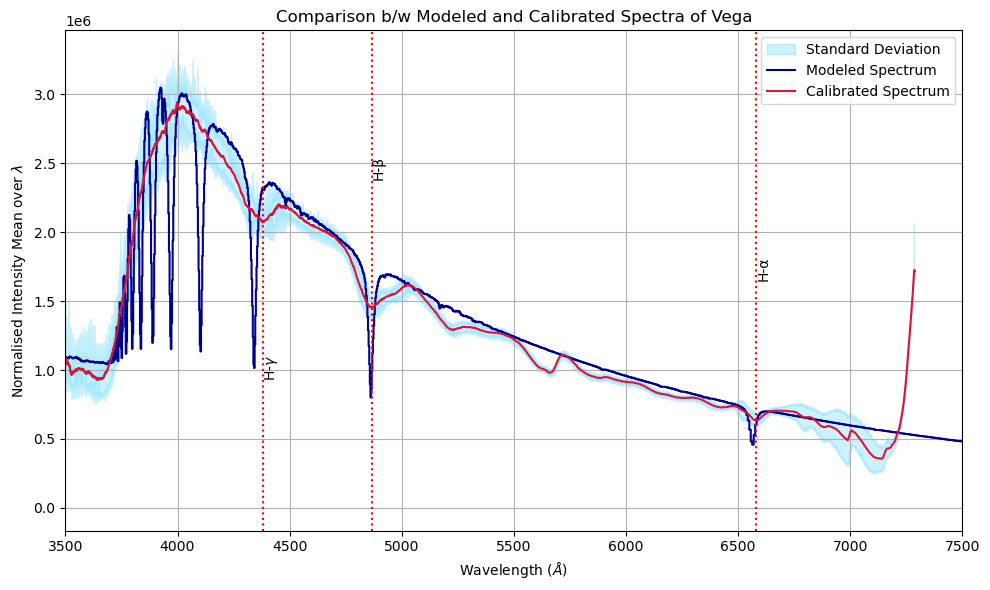

In [38]:
#STUPIDER
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from sbpy.calib import Vega
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.constants import h, c, k
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


wrange = 3000, 7500
d = 1 + 1 / 25
n = int(np.ceil(np.log(wrange[1] / wrange[0]) / np.log(d)))
wave_binned = wrange[0] * d**np.arange(n) * u.AA
# Get the default Vega spectrum and rebin it
vega = Vega.from_default()

temperature = 10000

bin_width = 1
wavelength_range_angstrom = np.arange(3000, 7500+bin_width, bin_width)  # in Angstr

fluxd_binned = vega.observe(wavelength_range_angstrom*u.AA, unit='W / (m2 um)')


min_distance = 1
prominence = 1e-16

peaks, _ = find_peaks(vega.fluxd.to('W / (m2 um)'), distance=min_distance, prominence=prominence)
dips_vega, _ = find_peaks(-1*vega.fluxd.to('W / (m2 um)'), distance=min_distance, prominence=prominence*6e7)
dips_vega_w = vega.wave.to('AA')[dips_vega]

new_intensity = vega.fluxd.to('W / (m2 um)')[peaks]

interpolator = interp1d(vega.wave.to('AA')[peaks], new_intensity, kind='linear', fill_value='extrapolate')
new_intensity_interpolated = interpolator(vega.wave.to('AA'))

new_intensity_savgol = savgol_filter(new_intensity_interpolated, window_length=50, polyorder=4)
new_intensity_savgol = savgol_filter(new_intensity_savgol, window_length=100, polyorder=2)



plt.figure(figsize=(10,6))
plt.fill_between(bins, global_mean_intensity - bin_std_dev, global_mean_intensity + bin_std_dev, color='deepskyblue', alpha=0.2, label='Standard Deviation')
plt.plot(vega.wave.to('AA').value, vega.fluxd.to('W / (m2 um)')*3.5e13, drawstyle='steps-mid', color='darkblue',linestyle='-', label='Modeled Spectrum')
#plt.plot(bins, global_mean_intensity,'b-', label='Mean Normalised Spectrum',markersize=3)
plt.plot(bins, smooth, linestyle='solid', color='crimson', label='Calibrated Spectrum')
#plt.plot([bins[pixel_position] for pixel_position in dips], [smooth[pixel_position] for pixel_position in dips], 'ro', markersize=4.5, label='Detected Dips')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Normalised Intensity Mean over $\lambda$')
plt.title('Comparison b/w Modeled and Calibrated Spectra of Vega')
plt.xlim(3500,7500)
plt.legend()
plt.grid(True)

h_alpha_wavelength = 6581  
plt.axvline(x=h_alpha_wavelength, color='r', linestyle=':', label='H-α')
plt.text(h_alpha_wavelength, plt.ylim()[1] - 0.5 * (plt.ylim()[1] - plt.ylim()[0]), 'H-α', rotation=90, verticalalignment='bottom')

h_beta_wavelength = 4866  
plt.axvline(x=h_beta_wavelength, color='r', linestyle=':', label='H-β')
plt.text(h_beta_wavelength, plt.ylim()[1] - 0.3 * (plt.ylim()[1] - plt.ylim()[0]), 'H-β', rotation=90, verticalalignment='bottom')

h_gamma_wavelength = 4382  
plt.axvline(x=h_gamma_wavelength, color='r', linestyle=':', label='H-$\gamma$')
plt.text(h_gamma_wavelength, plt.ylim()[1] - 0.7 * (plt.ylim()[1] - plt.ylim()[0]), 'H-$\gamma$', rotation=90, verticalalignment='bottom')


plt.tight_layout()
plt.savefig('Compared Vega Spectrum.png')
plt.show()

In [9]:
vega.wave.to('AA').value

array([9.00452026e+02, 9.01354000e+02, 9.02258000e+02, ...,
       2.99353200e+06, 2.99653275e+06, 2.99953700e+06])

In [10]:
bins

array([3362, 3365, 3367, ..., 7286, 7287, 7288])